In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Regression Tree with Tada ETA data



*   ATA: Actual Time of Arrival
*   ETA: Expected Time of Arrival
*   api_eta: 앱 API에서 예측된 ETA



In [114]:
tada_eta = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/tada_eta.xlsx')
print(tada_eta.columns)
tada_eta.head()

Index(['ATA', 'id', 'api_eta', 'created_at_kst', 'month', 'pickup_lng',
       'pickup_lat', 'pickup_gu', 'driver_id', 'driver_lng', 'driver_lat',
       'hour'],
      dtype='object')


,ATA,id,api_eta,created_at_kst,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour
0,10.60,R4L9FL6NVEL4D0,5.65,2019-12-01T00:55:09,12,127.091399,37.624545,노원구,DST52944,127.069978,37.616472,0
1,9.20,R3A7JBY7CS6TPD,8.60,2019-12-01T00:09:39,12,127.023351,37.625564,강북구,DPC72995,127.026479,37.604711,0
2,10.85,R2BIUY1TDK14XE,10.53,2019-12-15T00:18:42,12,126.881154,37.481641,금천구,DPP94923,126.906225,37.452167,0
3,5.52,R31PU5GNHSGU6C,1.92,2019-07-31T00:24:11,7,126.988375,37.567897,중구,DCT73585,126.991170,37.566416,0
4,8.60,R41WR6N1VT42DJ,7.10,2019-07-05T00:40:34,7,126.988684,37.566716,중구,DPJ86237,127.006860,37.571164,0


In [115]:
tada_eta['distance'] = ((tada_eta['pickup_lat']-tada_eta['driver_lat'])**2 + (tada_eta['pickup_lng']-tada_eta['driver_lng'])**2)*100000
tada_eta = tada_eta.drop(['id', 'created_at_kst', 'driver_id', 'pickup_lng', 'pickup_lat', 'driver_lng','driver_lat','pickup_gu'],1)
tada_eta.head()

# sklearn의 tree는 범주 데이터는 다루지 못함. 이 경우에 one-hot encoding은 비효율적. 구 데이터도 활용하고 싶다면 h2o 참고

,ATA,api_eta,month,hour,distance
0,10.60,5.65,12,0,52.400202
1,9.20,8.60,12,0,44.465889
2,10.85,10.53,12,0,149.731535
3,5.52,1.92,7,0,1.000535
4,8.60,7.10,7,0,35.014797


In [116]:
tada_eta = tada_eta.sample(frac=1, random_state=0).reset_index(drop=True)
tada_eta.head()

,ATA,api_eta,month,hour,distance
0,6.13,8.32,12,22,44.521977
1,5.37,3.05,12,11,3.989066
2,6.27,5.00,7,19,4.814699
3,10.52,8.47,12,21,77.341173
4,12.45,6.65,7,12,14.888851


In [117]:
tada_eta.shape

(13916, 5)

In [118]:
train = tada_eta[:12000]
test = tada_eta[12000:]

In [119]:
x_train = np.asarray(train.drop('ATA',1))
y_train = np.asarray(train['ATA'])
x_test = np.asarray(test.drop('ATA',1))
y_test = np.asarray(test['ATA'])
eta_features = [x for i,x in enumerate(tada_eta.columns) if i!=0]

In [120]:
eta_features

['api_eta', 'month', 'hour', 'distance']

In [122]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble

#### 실습코드: Gradient Boosting 사용

In [130]:
reg = ensemble.GradientBoostingRegressor(
           n_estimators=100, 
           max_depth=3, 
           min_samples_leaf=5,
           learning_rate=0.05,
           loss='ls')
reg.fit(x_train, y_train)

mse = mean_squared_error(y_test, reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))

mae = mean_absolute_error(y_test, reg.predict(x_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_test[:,0]) ))

The mean squared error (MSE) on test set: 8.4021
The initial error of API ETA on test set: 13.7135
The mean absolute error (MAE) on test set: 2.0853
The initial error of API ETA on test set: 2.7047


#### 예시 1: Gradient Boosting Parameter 변경


In [252]:
reg = ensemble.GradientBoostingRegressor(
           n_estimators=300, 
           max_depth=3, 
           min_samples_leaf=100,
           learning_rate=0.03,
           max_features='sqrt',
           loss='ls',
           random_state=0
           )
reg.fit(x_train, y_train)

mse = mean_squared_error(y_test, reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))

mae = mean_absolute_error(y_test, reg.predict(x_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_test[:,0]) ))

The mean squared error (MSE) on test set: 8.2577
The initial error of API ETA on test set: 13.7135
The mean absolute error (MAE) on test set: 2.0676
The initial error of API ETA on test set: 2.7047


#### 예시 2: RandomForestRegressor 사용


In [247]:
reg = ensemble.RandomForestRegressor(
           n_estimators=100,  
           min_samples_leaf=1,
           max_depth=10,
           max_features='sqrt',
           criterion='mse',
           random_state=0,
           max_samples=0.07,
           ccp_alpha=0.01)
reg.fit(x_train, y_train)

mse = mean_squared_error(y_test, reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))

mae = mean_absolute_error(y_test, reg.predict(x_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_test[:,0]) ))

The mean squared error (MSE) on test set: 8.3519
The initial error of API ETA on test set: 13.7135
The mean absolute error (MAE) on test set: 2.0801
The initial error of API ETA on test set: 2.7047


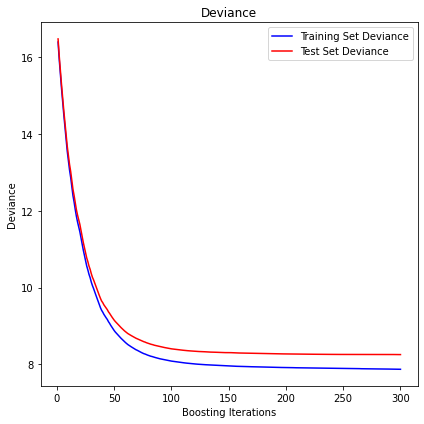

In [256]:
params={'n_estimators': 300}
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

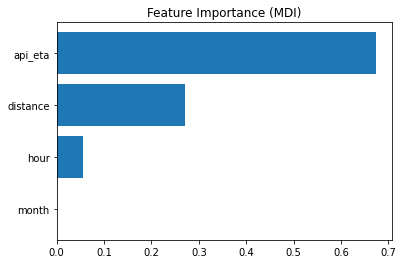

In [257]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure()
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(eta_features)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.show()